## Importing Libraries

In [180]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

from glob import glob

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, median_absolute_error
from sklearn.linear_model import LinearRegression

from pylab import rcParams

import warnings
warnings.filterwarnings('ignore')

## Importing Data

In [181]:
# List of filenames containing our FOREX data
forex_tables_glob = glob("../data/*.xls")

def create_forex_df(all_files_glob=glob("../data/*.xls")):

    all_files = all_files_glob

    li = []

    for filename in all_files:
        tdf = pd.read_excel(filename, skiprows=5, na_values=['CLOSED', 'closed', 'Closed', ' --']).drop([0,1,2,3,4])
        tdf = tdf.rename(columns={'Units':'Date'})

        # Convert Date to Datetime type
        tdf['Date'] = pd.to_datetime(tdf['Date'])

        # Create time series index
        tdf = tdf.set_index('Date', drop=True)
        li.append(tdf)

    df = pd.concat(li, axis=0, sort=False)
    
    return df

data = create_forex_df(forex_tables_glob).astype('float')

## Train, Validation, Test Split

Train Data : 2017 to 2018\
Validation Data : 2019\
Test Data : Jan 2020 to Feb 2020

In [182]:
# Data after 2017 (past 3 years)
data_3yrs = data['2017':]
df = data_3yrs[['USD']]

print("Total data count = ", df.shape[0])
print("Number of missing values = ", df.isnull().sum().sum())
print()

# for i in range(1, 11):
#     label = "lag_{}".format(i)
#     df[label] = df['USD'].shift(i)
    
df = df.dropna(axis=0)

train_ts = df['2017':'2018']
val_ts = df['2019']
test_ts = df['2020']

train_cv = df['2017':'2019']

print("Count of dates in training data = ", train_ts.shape[0])
print("Count of dates in validation data = ", val_ts.shape[0])
print("Count of dates in test data = ", test_ts.shape[0])

Total data count =  802
Number of missing values =  0

Count of dates in training data =  501
Count of dates in validation data =  251
Count of dates in test data =  50


#### Functions

1. Backtest
2. Random Simulation

In [183]:
def backtest(y, y_pred, initial_investment=1000, trade_amount=100):

    bsdf = pd.DataFrame(zip(y, y_pred), index = y.index, columns=['USD', 'Predictions'])
    
    bsdf['predicted_change'] = bsdf['Predictions'].diff().shift(-1)
    bsdf['buy'] = bsdf['predicted_change'].apply(lambda x: 1 if x >0 else (2 if x==0 else 0))

    logs = []
    profits = []

    strategy = bsdf.buy
    wallet = initial_investment
    
    for i in range(len(strategy)-1):
        rate_today = y[i]
        rate_future = y[i+1]
        buy = strategy[i]
#         print(buy)

        trade_money = trade_amount * rate_today
        wallet -= trade_amount

        if buy == 0:
            profit = trade_money - trade_amount * rate_future
        elif buy == 1:
            profit = trade_amount * rate_future - trade_money
        elif buy == 2:
            profit = 0
       
        
        if profit >= 0:
            wallet += trade_amount + profit
        else:
            wallet += trade_amount + profit

        logs.append(wallet)

    net_profit = wallet - initial_investment
    
#     plt.plot(bsdf.index[1:], logs)
#     plt.xticks(rotation=90)
#     plt.legend(["Net Profit = %.2f"%(net_profit)])
#     plt.title("Investment Growth over time")
#     plt.show()

    return net_profit, logs


def random_simulation(simulation_rate, ar_profit_on_same_data, limit=0.3, ax=plt):
    initial_investment = 1000
    trade_amount = 100

    profits = []

    for it in range(5000):

        random_strategy = np.random.randint(2, size=len(simulation_rate))

        wallet = initial_investment
        logs = []

        for i in range(len(random_strategy)-1):
            rate_today = simulation_rate[i]
            rate_future = simulation_rate[i+1]
            buy = random_strategy[i]

            trade_money = trade_amount * rate_today
            wallet -= trade_amount

            if buy == 0:
                profit = trade_money - trade_amount * rate_future
            elif buy == 1:
                profit = trade_amount * rate_future - trade_money
            elif buy == 2:
                profit = 0


            if profit >= 0:
                wallet += trade_amount + profit
            else:
                wallet += trade_amount + profit

            logs.append(wallet)

        net_profit = wallet - initial_investment

        profits.append(net_profit)
        
    legend_label = "Profit = %0.2f"%ar_profit_on_same_data
    
    max_profit = backtest(simulation_rate, simulation_rate)[0]
    
    from scipy.stats import norm
#     ax = sns.distplot(x, fit=norm, kde=False)
    sns.distplot(profits)
    ax.set_xlabel("Profit", fontsize=16)
    ax.set_ylabel("Distribution", fontsize=16)
    ax.set_title("Model Forecast", fontsize=16)
    ax.vlines(ar_profit_on_same_data, 0, limit, label='Profit with model')
    ax.vlines(max_profit, 0, limit, label='Max Possible Profit')
    ax.legend(["Profit = %0.2f"%ar_profit_on_same_data])
#     plt.show()

    return profits

In [184]:
ts = data_3yrs[['USD', 'Index', 'EUR', 'GBP']]

h = 16
h_lagged_features = ts.shift(h).dropna()

h_lagged_features.columns = ['USD_lagged_{}'.format(h), 
                    'Index_lagged_{}'.format(h),
                    'EUR_lagged_{}'.format(h),
                    'GBP_lagged_{}'.format(h)]

labels = ts.loc[h_lagged_features.index][['USD']]

print(h_lagged_features.info())
print()
print(labels.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 786 entries, 2017-01-25 to 2020-03-12
Data columns (total 4 columns):
USD_lagged_16      786 non-null float64
Index_lagged_16    786 non-null float64
EUR_lagged_16      786 non-null float64
GBP_lagged_16      786 non-null float64
dtypes: float64(4)
memory usage: 30.7 KB
None

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 786 entries, 2017-01-25 to 2020-03-12
Data columns (total 1 columns):
USD    786 non-null float64
dtypes: float64(1)
memory usage: 12.3 KB
None


In [185]:
pd.concat([h_lagged_features, labels], axis=1).head(20)

,USD_lagged_16,Index_lagged_16,EUR_lagged_16,GBP_lagged_16,USD
Date,,,,,
2017-01-25,0.7234,64.0,0.6897,0.5879,0.7543
2017-01-27,0.7240,64.2,0.6960,0.5914,0.7528
2017-01-30,0.7302,64.3,0.6936,0.5919,0.7552
2017-01-31,0.7318,64.3,0.6916,0.5911,0.7567
2017-02-01,0.7310,64.6,0.6944,0.5977,0.7566
2017-02-02,0.7374,64.8,0.6951,0.6070,0.7638
2017-02-03,0.7381,65.0,0.6996,0.6070,0.7653
2017-02-06,0.7462,65.4,0.7040,0.6113,0.7665
2017-02-07,0.7485,65.6,0.7049,0.6152,0.7671


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001A829A34588>,
      dtype=object)

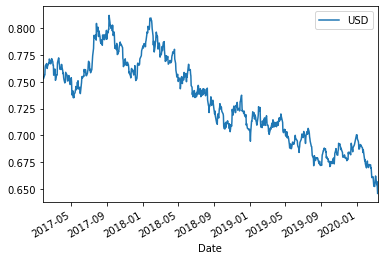

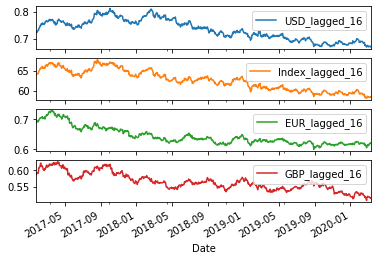

In [186]:
labels.plot()
h_lagged_features.plot(subplots=True)

In [187]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor, XGBRFRegressor

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, median_absolute_error

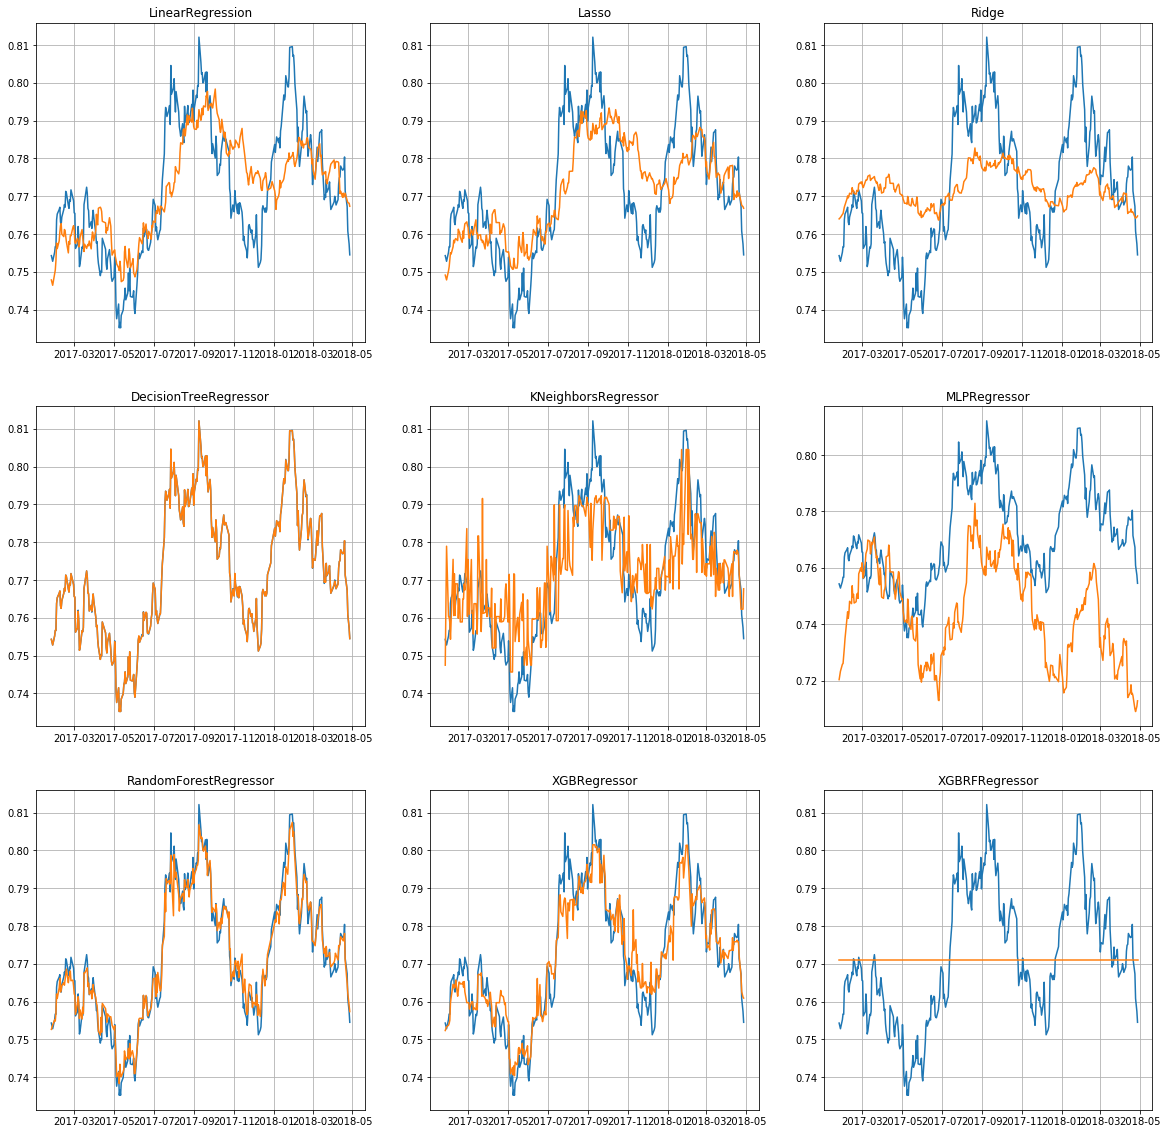

In [188]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(h_lagged_features, labels, test_size = 0.6, shuffle=False)

model_labels = ['LinearRegression',
          'Lasso',
          'Ridge',
          'DecisionTreeRegressor',
          'KNeighborsRegressor',
          'MLPRegressor',
          'RandomForestRegressor',
          'XGBRegressor',
          'XGBRFRegressor',
         ]

models = [LinearRegression(),
          Lasso(alpha=0.00001),
          Ridge(),
          DecisionTreeRegressor(),
          KNeighborsRegressor(),
          MLPRegressor(shuffle=False, random_state=42),
          RandomForestRegressor(),
          XGBRegressor(objective='reg:squarederror'),
          XGBRFRegressor(objective='reg:squarederror', learning_rate=1)]

fig, ax = plt.subplots(3,3, figsize=(20,20))

for i, (model, name) in enumerate(zip(models, model_labels)):
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_train)
    

    ax[int(i/3)][i%3].plot(y_train)
    ax[int(i/3)][i%3].plot(y_train.index, y_pred)
    ax[int(i/3)][i%3].set_title(name)
    ax[int(i/3)][i%3].grid()

fig.show()

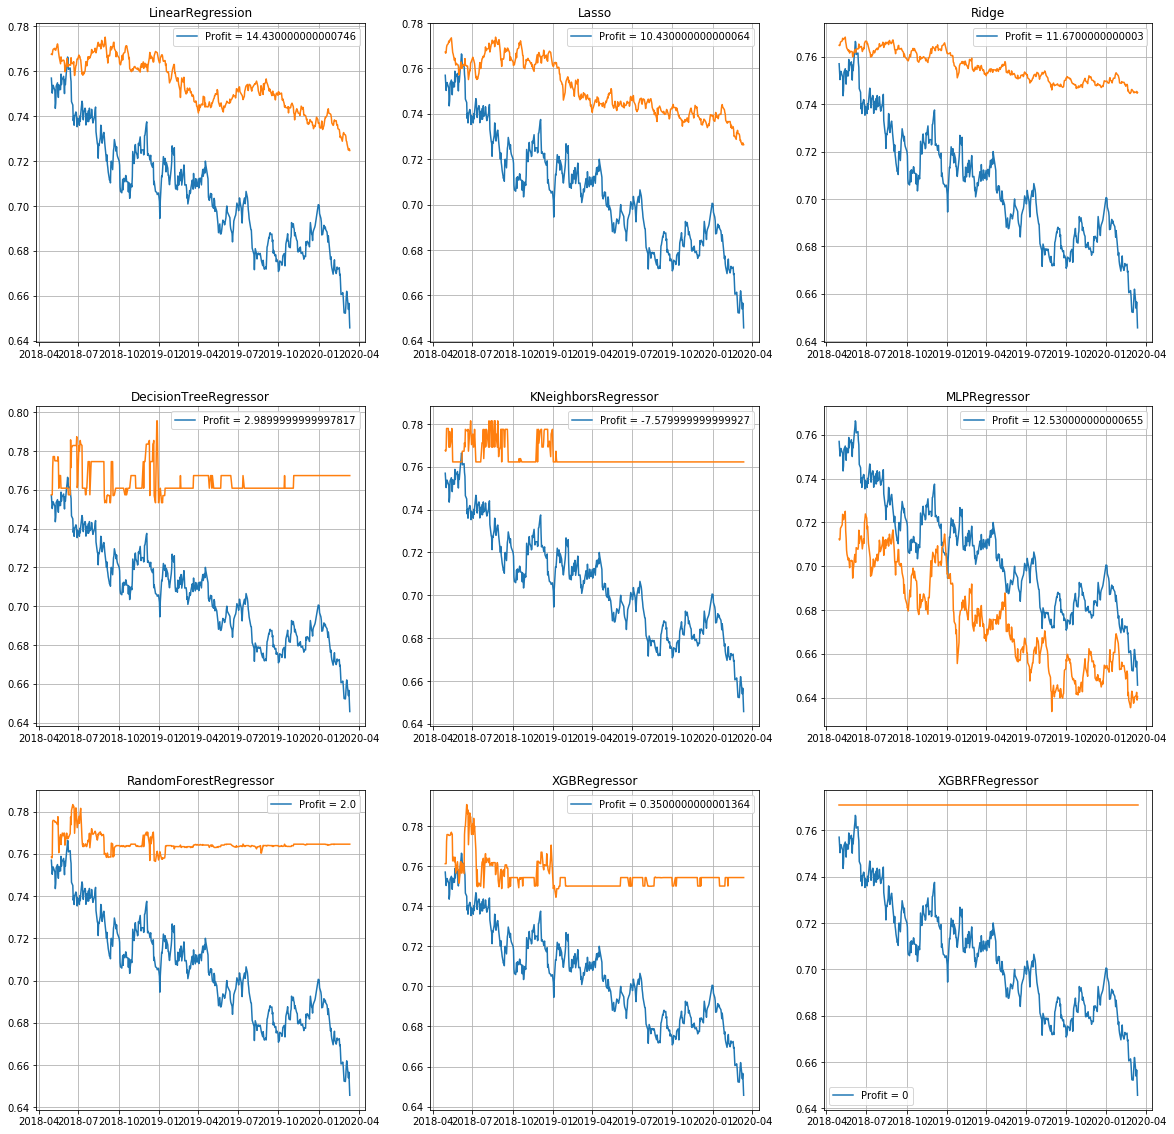

In [189]:
fig, ax = plt.subplots(3,3, figsize=(20,20))

for i, (model, name) in enumerate(zip(models, model_labels)):
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    

    ax[int(i/3)][i%3].plot(y_test)
    ax[int(i/3)][i%3].plot(y_test.index, y_pred)
    ax[int(i/3)][i%3].set_title(name)
    ax[int(i/3)][i%3].grid()
    
    profit = backtest(y_test['USD'], y_pred)[0]
    ax[int(i/3)][i%3].legend(["Profit = {}".format(profit)])
    
fig.show()

Actual = 0.665,  Predicted = 0.7458087257611379
Actual = 0.6605,  Predicted = 0.7451110926165214
Actual = 0.6609,  Predicted = 0.7444347538868386
Actual = 0.6614,  Predicted = 0.7447663759063988
Actual = 0.6596,  Predicted = 0.7449105818592149
Actual = 0.6555,  Predicted = 0.7459884718746073
Actual = 0.6524,  Predicted = 0.7461598043898171
Actual = 0.6522,  Predicted = 0.7453887310043884
Actual = 0.6552,  Predicted = 0.744928187662028
Actual = 0.6595,  Predicted = 0.7447318618075965
Actual = 0.662,  Predicted = 0.7451313941900561
Actual = 0.6602,  Predicted = 0.7449905292110726
Actual = 0.6539,  Predicted = 0.7449325665972975
Actual = 0.6566,  Predicted = 0.7453348698573197
Actual = 0.6505,  Predicted = 0.7445605813413341
Actual = 0.6457,  Predicted = 0.7448399249162694


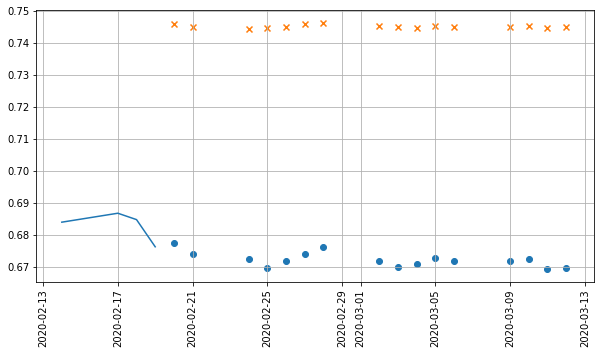

In [190]:
ridge = Ridge()
ridge.fit(X_train, y_train)
predicted = ridge.predict(X_test[-h:]) 

actual = y_test[-h:]

for i in range(len(actual)):
    print("Actual = {},  Predicted = {}".format(actual.iloc[i].values[0], predicted[i][0]))
    
fig, ax = plt.subplots(figsize=(10,5))

col = 'USD_lagged_{}'.format(h)

ax.plot(X_test[-20:-h][col])
ax.scatter(X_test[-h:][col].index, X_test[-h:][col])
ax.scatter(X_test[-h:][col].index, predicted, marker='x')
# ax.plot(actual.index, predicted)
ax.grid()
plt.xticks(rotation=90)
# ax.legend(["Profit = {}".format(backtest(actual['USD'], predicted)[0])])
fig.show()

----------------------------------------------------------------------------------------------------


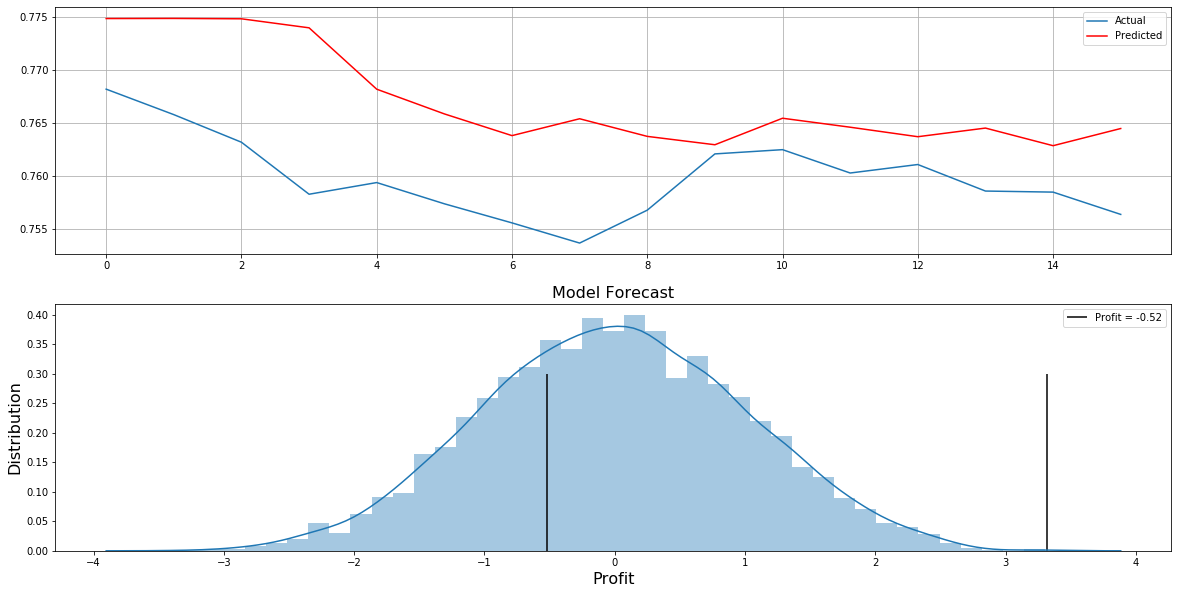

In [199]:
# Start and end indices for training data
start = 0
end = start + 200

train = h_lagged_features[start : end]
train_labels = labels[start : end]

test_features = h_lagged_features[end : end + h]
y = labels[end : end+h]

model = Ridge()
model.fit(train, train_labels)

predictions = model.predict(test_features)

model_profit, equity = backtest(y['USD'], predictions)

fig, ax = plt.subplots(2, figsize=(20,10))

ax[0].plot(y.values)
ax[0].plot(predictions, color='r')
ax[0].grid()
ax[0].legend(['Actual', 'Predicted'])

random_simulation(y['USD'], model_profit, ax=ax[1])
# naive_max_profit = backtest

fig.show()

print("-"*100)

In [200]:
len(predictions)
len(y)

16

In [201]:
predictions

array([[0.77485305],
       [0.77486403],
       [0.7748292 ],
       [0.77397906],
       [0.76819608],
       [0.76586855],
       [0.76382261],
       [0.76541238],
       [0.76375107],
       [0.76296314],
       [0.76546104],
       [0.76461492],
       [0.76371992],
       [0.76453401],
       [0.76287308],
       [0.76449193]])

In [202]:
test_features

,USD_lagged_16,Index_lagged_16,EUR_lagged_16,GBP_lagged_16
Date,,,,
2017-11-10,0.7852,66.2,0.6653,0.5941
2017-11-13,0.7845,66.2,0.6640,0.5987
2017-11-14,0.7826,66.2,0.6649,0.5929
2017-11-15,0.7819,66.1,0.6648,0.5913
2017-11-16,0.7720,65.4,0.6566,0.5879
2017-11-17,0.7706,65.1,0.6516,0.5809
2017-11-20,0.7642,64.9,0.6568,0.5820
2017-11-21,0.7677,65.1,0.6608,0.5839
2017-11-22,0.7673,64.9,0.6600,0.5814


In [203]:
train = pd.concat([ts, ts['2018-03'][:h]], axis=0)
ts['2018-03'][:h]

,USD,Index,EUR,GBP
Date,,,,
2018-03-01,0.7731,63.2,0.6340,0.5623
2018-03-02,0.7756,63.3,0.6315,0.5627
2018-03-05,0.7752,63.2,0.6291,0.5620
2018-03-06,0.7773,63.4,0.6295,0.5617
2018-03-07,0.7804,63.4,0.6286,0.5617
2018-03-08,0.7830,63.7,0.6311,0.5631
2018-03-09,0.7792,63.5,0.6328,0.5646
2018-03-12,0.7869,64.0,0.6385,0.5677
2018-03-13,0.7870,64.1,0.6384,0.5666


In [204]:
actual

Date
2018-03-21    0.7697
2018-03-22    0.7744
2018-03-23    0.7711
2018-03-26    0.7723
2018-03-27    0.7738
2018-03-28    0.7694
2018-03-29    0.7665
2018-04-03    0.7685
2018-04-04    0.7700
2018-04-05    0.7690
2018-04-06    0.7677
2018-04-09    0.7691
2018-04-10    0.7733
2018-04-11    0.7749
2018-04-12    0.7751
2018-04-13    0.7780
Name: USD, dtype: float64

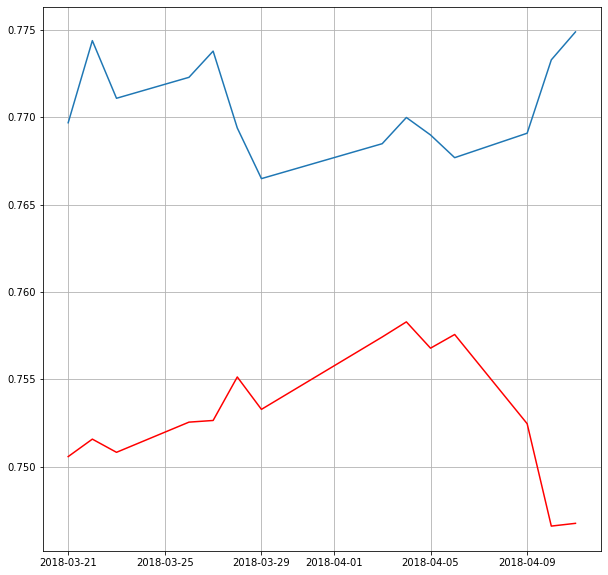

In [210]:
actual = ts['2018-03-21':][:14]['USD']
# model.fit()
predicted = model.predict(ts['2018-03'][:14])

fig, ax = plt.subplots(figsize=(10,10))

ax.plot(actual.index, actual)
ax.plot(actual.index, predicted, color='red')
ax.grid()

In [ ]:
model_profit, equity = backtest(actual, predicted)

fig, ax = plt.subplots(figsize=(10,10))
_ = random_simulation(actual, model_profit, ax=ax)

#### Last Value Benchmark

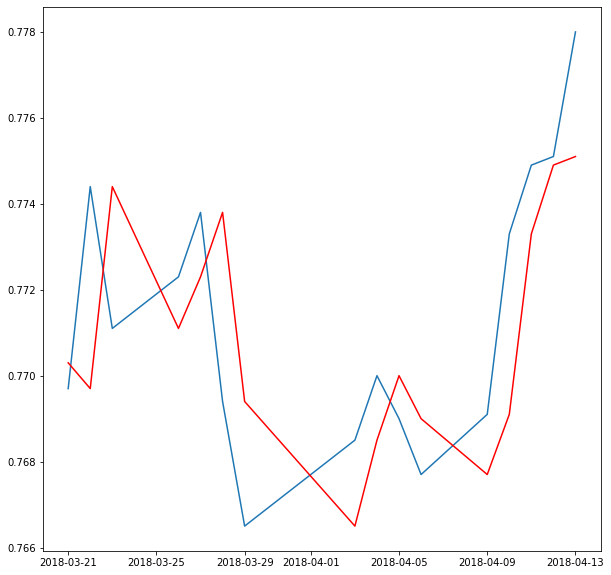

In [206]:
predicted = actual.shift().fillna(0.7703)

fig, ax = plt.subplots(figsize=(10,10))

ax.plot(actual.index, actual)
ax.plot(actual.index, predicted, color='red')

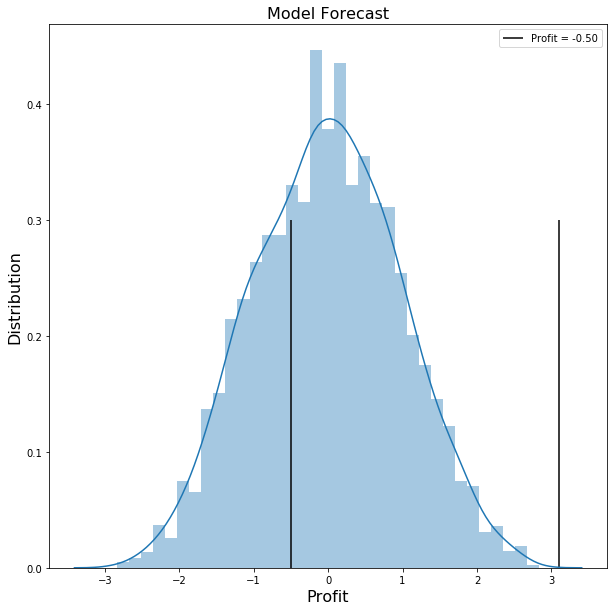

In [20]:
model_profit, equity = backtest(actual, predicted)

fig, ax = plt.subplots(figsize=(10,10))
_ = random_simulation(actual, model_profit, ax=ax)

Imagine that today is December 31, 2018. I have no idea about what the forex rate is going to be tomorrow.

HYPOTHESIS - I can predict tomorrow's exchange rate for the USD/AUD currency pair from the values of USD/AUD rate, Index, GBP/AUD rate and EUR/AUD rate from **14** working days ago.

Model will be trained on data from before December 2018 i.e. 2017 to November 2018.

Expectation - return profit **80%** of the times in all two week periods starting January 2019.

In [21]:
df_2019 = ts['2019']
no_h_day_periods = int(len(df_2019)/h)

print("Number of {} day periods in 2019 = {}".format(h, no_h_day_periods))

Number of 16 day periods in 2019 = 15


## Train model on data from 2017 to November 2018

In [211]:
X_train = ts['2017':'2018-11']
y_train = data[['USD']].shift(-h).loc[X_train.index]
y_train.columns = ['USD/AUD Rate {} days from today'.format(h)]

model = Ridge()
model_fit = model.fit(X_train, y_train)

Skip this


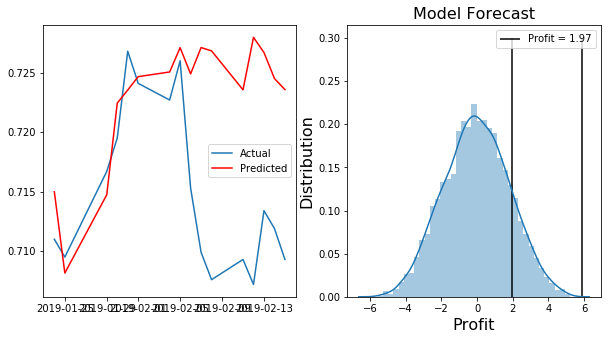

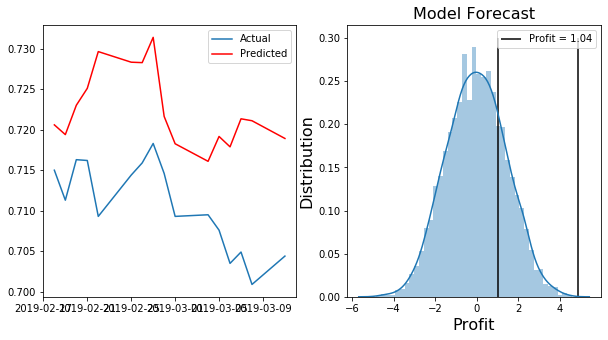

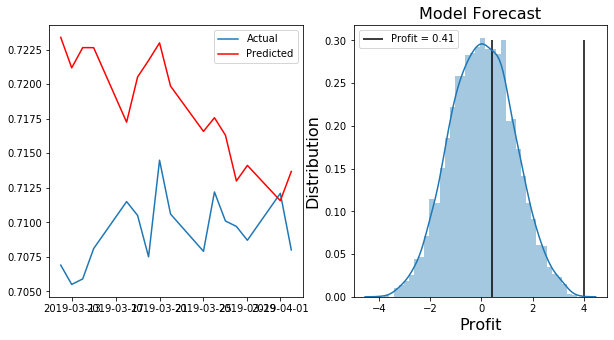

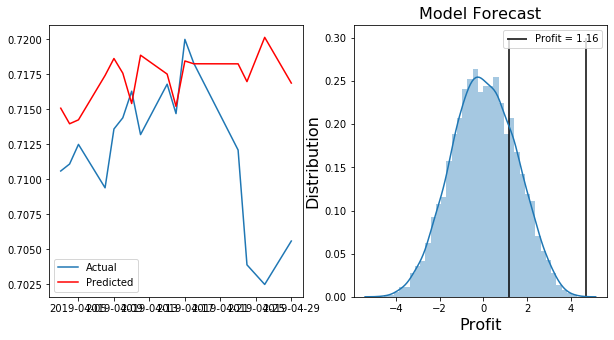

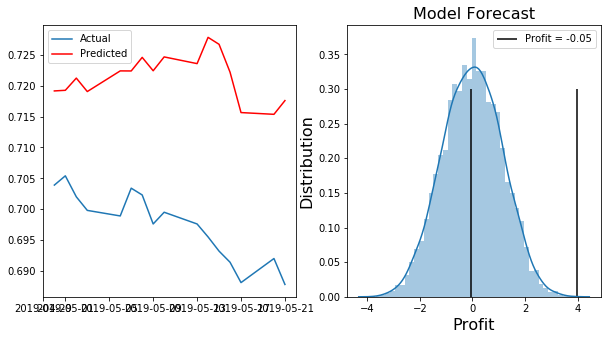

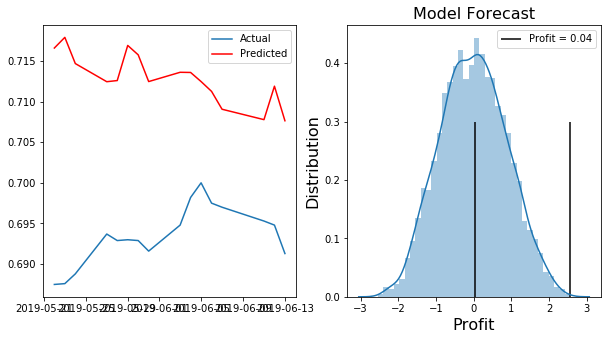

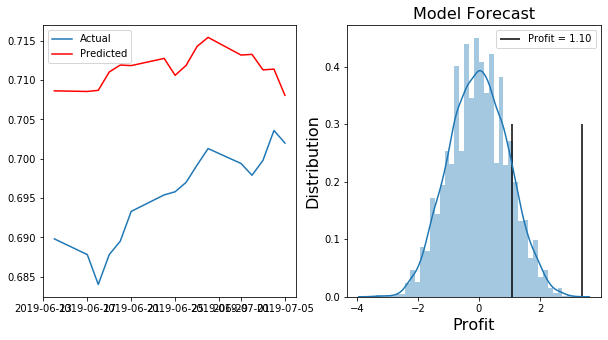

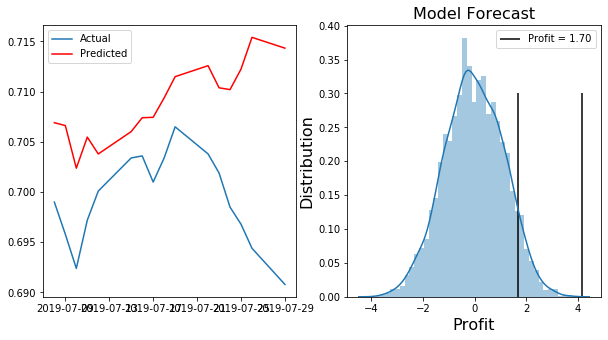

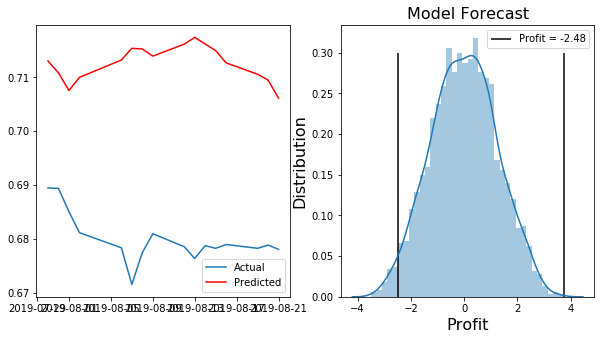

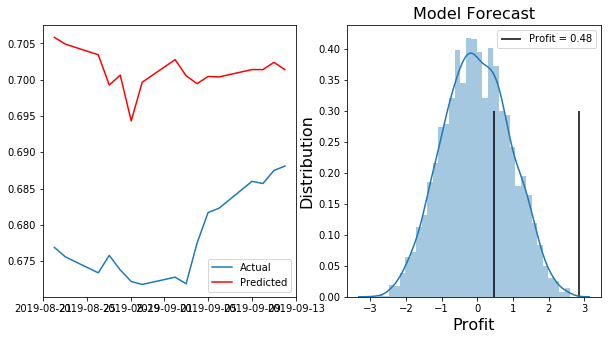

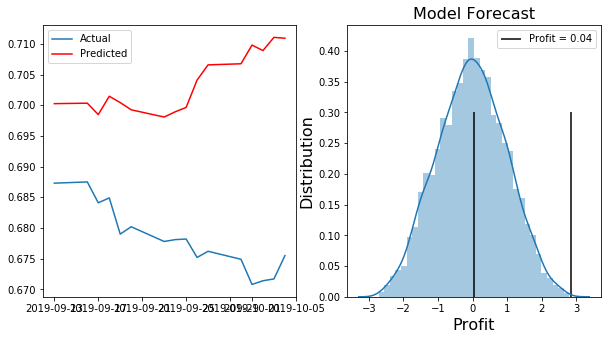

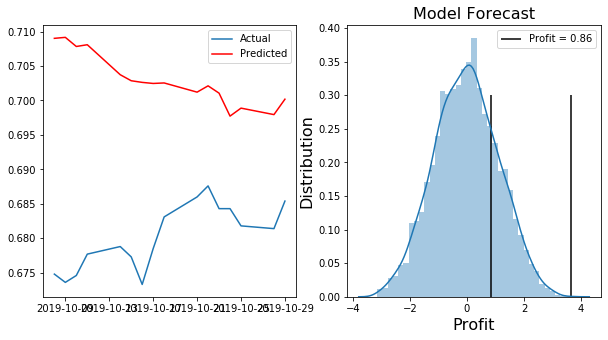

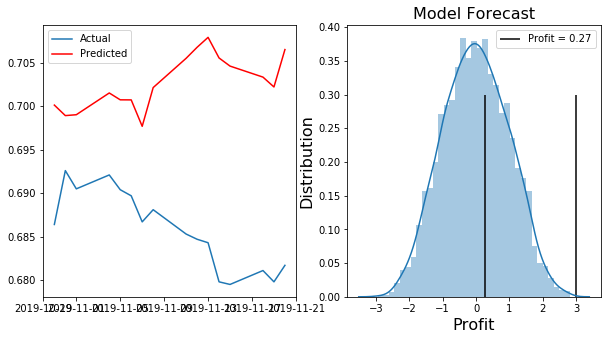

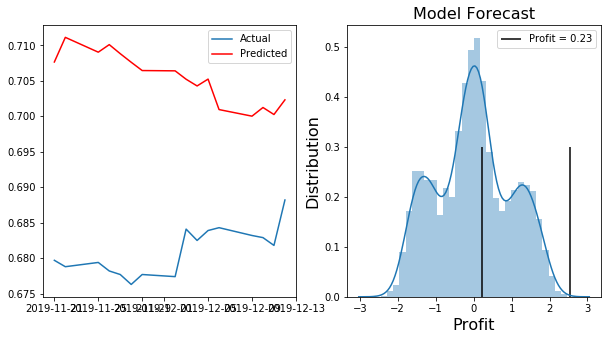

In [212]:
h = 16

period_id = np.arange(0, h * no_h_day_periods, h)

h_profits = []
period_start_dates = []

for start in period_id:
    end = start + h
    
    test = df_2019[start : end]
    
    if start == 0:
        print('Skip this')
    else:
        y = ts.loc[test.index]['USD']
        y_pred = model.predict(previous_16_days)
        
        fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,5))

        ax1.plot(y.index, y, label='Actual')
        ax1.plot(y.index, y_pred, color='red', label='Predicted')
        ax1.legend()
        
        model_profit, equity = backtest(y, y_pred)
        h_profits.append(model_profit)
        period_start_dates.append(test.index.min().date())

        _ = random_simulation(y, model_profit, ax=ax2)
        
        fig.show()
    
    previous_16_days = test
    
    

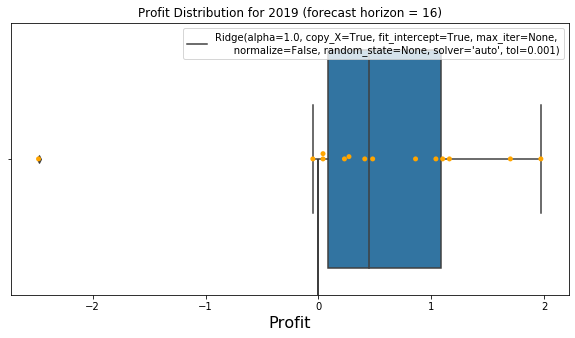

In [213]:
fig, ax = plt.subplots(figsize=(10,5))

sns.boxplot(h_profits)
sns.swarmplot(h_profits, color='orange')
ax.vlines(0, 0, 20, color='black')
ax.set_title("Profit Distribution for 2019 (forecast horizon = {})".format(h))
ax.set_xlabel("Profit", fontsize=16)
ax.legend([model])
plt.show()

In [214]:
p = np.array(h_profits) 
losses = p[p < 0]
profits = p[p >= 0]

profit_perc = len(profits) / (no_h_day_periods - 1) * 100

print("Percentage of periods with profit = {}".format(profit_perc))

Percentage of periods with profit = 85.71428571428571


For h = 14 :

**HYPOTHESIS failed i.e. just the information of 14 days ago is not sufficient for 80% profit percentage.**

# Write a function

- Inputs :
    1. FEATURES
    2. h = forecast horizon
    3. labels (eg. price after *h* days)
    4. model, default = Ridge()
- Outputs :
    1. Prints number of h day periods
    - Trains regression model on data from 2017 to November 2018
    2. Prints profit percentage
    3. Plots profit Boxplot

In [215]:
def model_evaluation(h, verbose=True, model=Ridge()):

    df_2019 = ts['2019']
    no_h_day_periods = int(len(df_2019)/h)
    
    if verbose==True:
        print("Number of {} day periods in 2019 = {}".format(h, no_h_day_periods))

    X_train = ts['2017':'2018-11']
    y_train = data[['USD']].shift(h).loc[X_train.index]
    y_train.columns = ['USD/AUD Rate {} days from today'.format(h)]

    model_fit = model.fit(X_train, y_train)

    period_id = np.arange(0, h * no_h_day_periods, h)

    h_profits = []
    period_start_dates = []

    for start in period_id:
        end = start + h

        test = df_2019[start : end]

    #     print("Start date = ", test.index.min().date())
    #     print("End date = ", test.index.max().date())

        if start == 0:
            None
        else:
            y = ts.loc[test.index]['USD']
            y_pred = model.predict(previous_h_days)

    #         fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,5))

    #         ax1.plot(y.index, y, label='Actual')
    #         ax1.plot(y.index, y_pred, color='red', label='Predicted')
    #         ax1.legend()

            model_profit, equity = backtest(y, y_pred)
            h_profits.append(model_profit)
            period_start_dates.append(test.index.min().date())

    #         _ = random_simulation(y, model_profit, ax=ax2)

#             fig.show()

        previous_h_days = test
    
    if verbose==True:
        fig, ax = plt.subplots(figsize=(10,5))

        sns.boxplot(h_profits)
        sns.swarmplot(h_profits, color='orange')
        ax.vlines(0, 0, 20, color='black')
        ax.set_title("Profit Distribution for 2019 (forecast horizon = {})".format(h))
        ax.set_xlabel("Profit", fontsize=16)
        ax.legend([model])
        fig.show()

    p = np.array(h_profits) 
    losses = p[p < 0]
    profits = p[p > 0]

    profit_perc = (len(profits) / (no_h_day_periods - 1)) * 100

    
    if verbose==True:
        print("{} : Percentage of periods with profit = {}".format(h, profit_perc))
    
    return profit_perc, np.median(p)

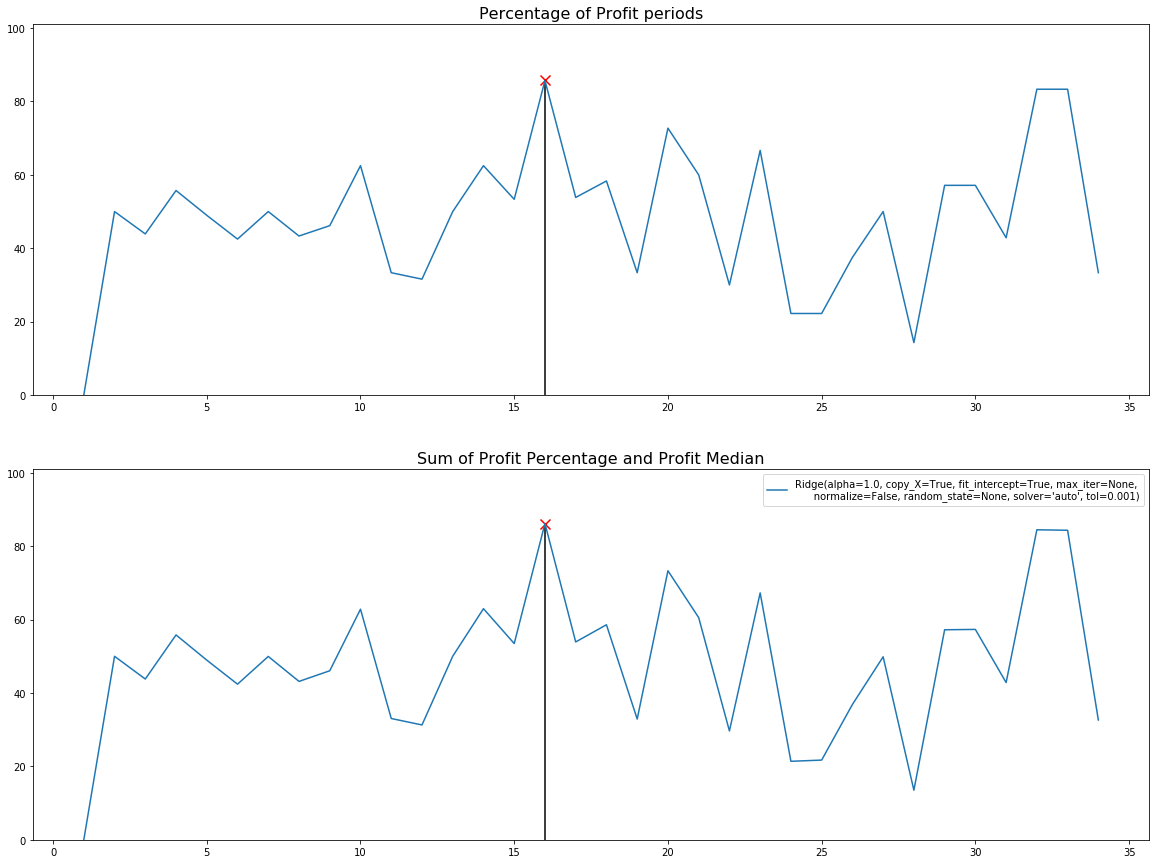

In [216]:
def plot_model_profit_metrics(H = np.arange(1, 35, 1), model=Ridge()):

    profit_percentages = []
    profit_medians = []

    for h in H:
        profit_perc, profit_median = model_evaluation(h, verbose=False, model=model)
        profit_percentages.append(profit_perc)
        profit_medians.append(profit_median)

    profit_percentages = np.asarray(profit_percentages)
    profit_medians = np.asarray(profit_medians)

    perc_median_sum = profit_medians + profit_percentages

    fig, (ax1, ax2) = plt.subplots(2, figsize=(20,15))

    max_perc = np.argmax(profit_percentages)
    max_sum = np.argmax(perc_median_sum)

    ax1.plot(H, profit_percentages)
    ax1.scatter(max_perc + 1, profit_percentages[max_perc], marker='x', s=100, c='red')
    ax1.vlines(max_perc+1, 0, profit_percentages[max_perc])
    ax1.set_ylim([0,101])
    ax1.set_title("Percentage of Profit periods", fontsize=16)

    ax2.plot(H, perc_median_sum)
    ax2.scatter(max_sum+1, perc_median_sum[max_sum], marker='x', s=100, c='red')
    ax2.vlines(max_sum+1, 0, perc_median_sum[max_sum])
    ax2.set_ylim([0,101])
    ax2.set_title("Sum of Profit Percentage and Profit Median", fontsize=16)
    
    ax2.legend([model])
    fig.show()
    
plot_model_profit_metrics()

For h = 16 :
**HYPOTHESIS CORRECT i.e. the information of 16 days ago IS sufficient for 80% profit percentage in 2019.**

## Does any other model perform even better (Ridge Regression, best profit percentage = 80%)

1. For h = 16

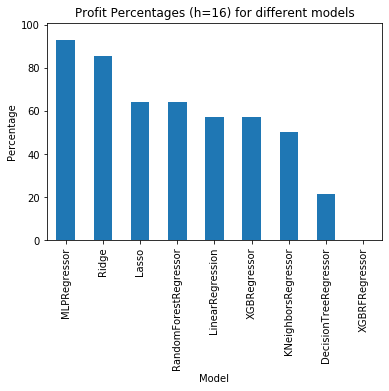

In [217]:
percentages = []

for model, name in zip(models, model_labels):
    profit_perc, profit_median = model_evaluation(h=16, verbose=False, model=model)
    percentages.append(profit_perc)
    
profit_perc_dict = {"Model" : model_labels, "Profit Percentage": percentages}

profit_perc_df = pd.DataFrame(profit_perc_dict).sort_values(by='Profit Percentage', ascending = False)
profit_perc_df.plot(kind='bar', x='Model', y='Profit Percentage', legend=False)
plt.title("Profit Percentages (h=16) for different models")
plt.ylabel("Percentage")
plt.ylim([0,101])
plt.show()

# MLP Regressor shows promising results. Let's find the optimal h value(s).

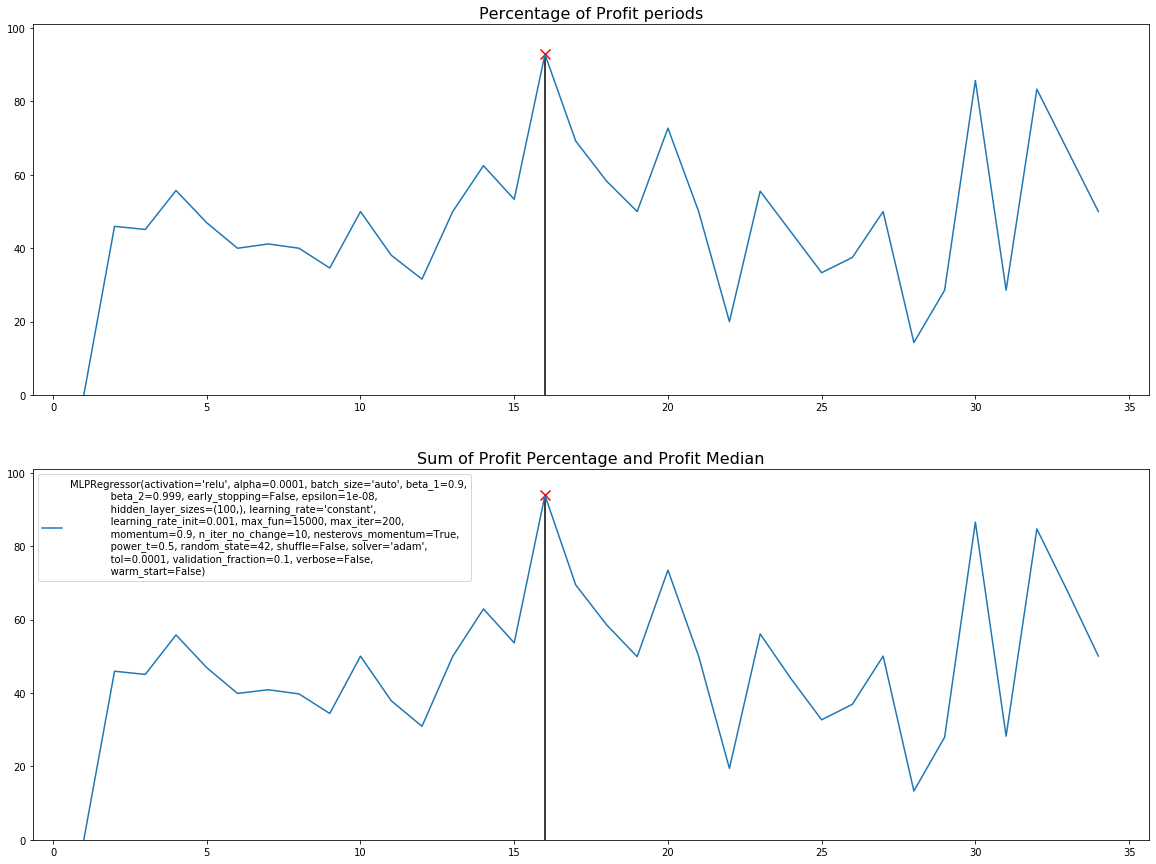

In [218]:
mlp = MLPRegressor(shuffle=False, random_state=42)
plot_model_profit_metrics(model= mlp)

# We get the best value of h = 16. Let's evaluate the MLPRegressor for h = 16.

Number of 16 day periods in 2019 = 15
16 : Percentage of periods with profit = 92.85714285714286


(92.85714285714286, 1.0200000000000955)

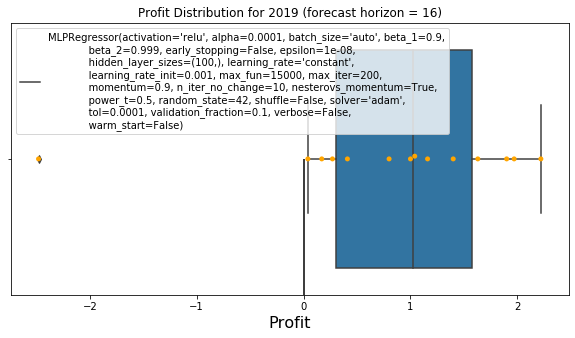

In [219]:
model_evaluation(h=16, model=mlp, verbose=True)

## Model Tuning

In [220]:
import itertools

activation = ['relu', 'identity', 'logistic', 'tanh']
tol = [0.0001, 0.001, 0.01, 0.1, 1, 10]
alpha = [0.0001, 0.001, 0.01, 0.1, 1, 10]
solver = ['sgd', 'adam']

parameters = list(itertools.product(activation, tol, alpha, solver))

profit_percs = []
profit_medians = []

for params in parameters:
    activation, tol, alpha, solver = params
    
    mlp = MLPRegressor(shuffle=False,
                       random_state=42,
                       activation=activation, 
                       tol=tol, 
                       alpha=alpha,
                       solver=solver)
    
#     print(params)
    profit_perc, profit_median = model_evaluation(h=16, model=mlp, verbose=False)
    
    profit_percs.append(profit_perc)
    profit_medians.append(profit_median)

In [221]:
mlp_df = pd.DataFrame({"activation, tol, alpha, solver" : parameters,
                       "profit_percentage" : profit_percs, 
                       "profit_median" : profit_medians})

mlp_df = mlp_df.sort_values(by=['profit_percentage','profit_median'], ascending=False).reset_index().drop('index', axis=1)

mlp_df.head(20)

,"activation, tol, alpha, solver",profit_percentage,profit_median
0,"(relu, 0.0001, 0.0001, adam)",92.857143,1.020
1,"(relu, 0.001, 0.0001, adam)",92.857143,1.020
2,"(relu, 0.001, 10, adam)",92.857143,1.020
3,"(relu, 0.01, 0.0001, adam)",92.857143,1.020
4,"(relu, 0.01, 0.001, adam)",92.857143,1.020
5,"(relu, 0.01, 0.01, adam)",92.857143,1.020
6,"(relu, 0.01, 0.1, adam)",92.857143,1.020
7,"(relu, 0.01, 1, adam)",92.857143,1.020
8,"(relu, 0.0001, 10, adam)",92.857143,0.920
9,"(tanh, 1, 0.0001, adam)",92.857143,0.615


In [222]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

mask = mlp_df.profit_percentage > 86

best_mlp_subset = mlp_df.loc[mask]

In [223]:
def other_metrics(model, verbose=False):

    df_2019 = ts['2019']
    no_h_day_periods = int(len(df_2019)/h)

    if verbose==True:
        print("Number of {} day periods in 2019 = {}".format(h, no_h_day_periods))

    X_train = ts['2017':'2018-11']
    y_train = data[['USD']].shift(h).loc[X_train.index]
    y_train.columns = ['USD/AUD Rate {} days from today'.format(h)]

    model_fit = model.fit(X_train, y_train)

    period_id = np.arange(0, h * no_h_day_periods, h)

    h_profits = []
    period_start_dates = []

    r2_scores = []
    mse_scores = []
    mae_scores = []

    for start in period_id:
        end = start + h

        test = df_2019[start : end]

    #     print("Start date = ", test.index.min().date())
    #     print("End date = ", test.index.max().date())

        if start == 0:
            None
        else:
            y = ts.loc[test.index]['USD']
            y_pred = model.predict(previous_h_days)
            
            mse = mean_squared_error(y, y_pred)
            mae = mean_absolute_error(y, y_pred)

            mse_scores.append(mse)
            mae_scores.append(mae)

        previous_h_days = test

    return np.mean(mse_scores), np.mean(mae_scores)    

In [224]:
mean_mse, mean_mae = [], []

for params in best_mlp_subset['activation, tol, alpha, solver']:
    activation, tol, alpha, solver = params
    
    model = MLPRegressor(shuffle=False,
                         random_state=42, 
                         tol=tol,
                         activation=activation,
                         alpha=alpha,
                         solver=solver)
    
    mse_cv, mae_cv = other_metrics(model=model)
    
    mean_mse.append(mse_cv)
    mean_mae.append(mae_cv)
    

In [225]:
best_mlp_subset['mse_cv'] = mean_mse
best_mlp_subset['mae_cv'] = mean_mae

best_mlp_subset = best_mlp_subset.sort_values(by=['mse_cv', 'mae_cv']).reset_index().drop('index', axis=1)
top4_mlp_subset = best_mlp_subset.head(4)
top4_mlp_subset

,"activation, tol, alpha, solver",profit_percentage,profit_median,mse_cv,mae_cv
0,"(relu, 0.0001, 10, adam)",92.857143,0.92,0.000109,0.008651
1,"(relu, 0.001, 10, adam)",92.857143,1.02,0.000115,0.008958
2,"(relu, 0.0001, 0.0001, adam)",92.857143,1.02,0.000214,0.011575
3,"(relu, 0.001, 0.0001, adam)",92.857143,1.02,0.000214,0.011575


## Visualize 4 best model predictions

- Trained on data from 2017 to November 2019

- Predictions on last h=16 days of December 2019 to get predictions of first h=16 days of January

In [226]:
# Last h=16 days of December 2019
test = ts['2019-12'][-16:]

In [227]:
ts['2020'][:16]['USD']

Date
2020-01-02    0.7003
2020-01-03    0.6966
2020-01-06    0.6945
2020-01-07    0.6928
2020-01-08    0.6871
2020-01-09    0.6873
2020-01-10    0.6873
2020-01-13    0.6914
2020-01-14    0.6902
2020-01-15    0.6899
2020-01-16    0.6907
2020-01-17    0.6895
2020-01-20    0.6884
2020-01-21    0.6865
2020-01-22    0.6839
2020-01-23    0.6867
Name: USD, dtype: float64

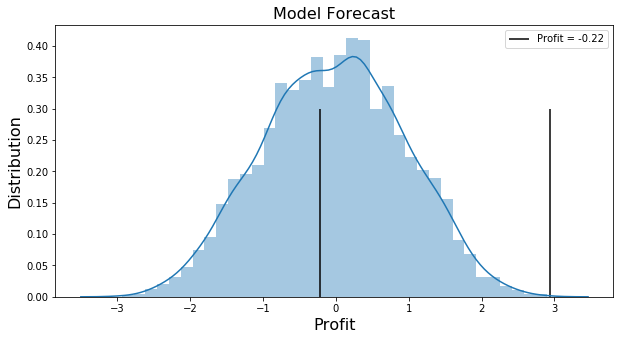

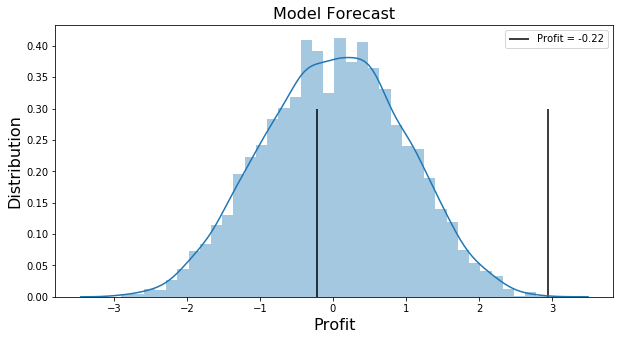

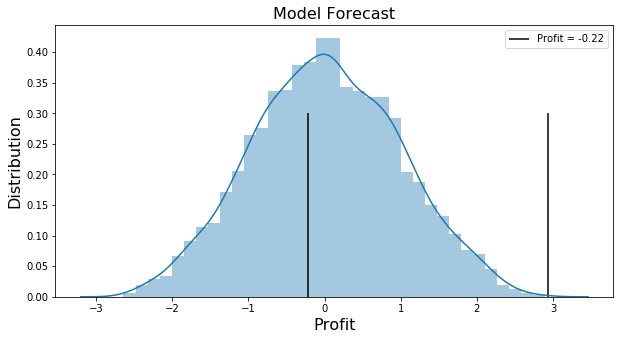

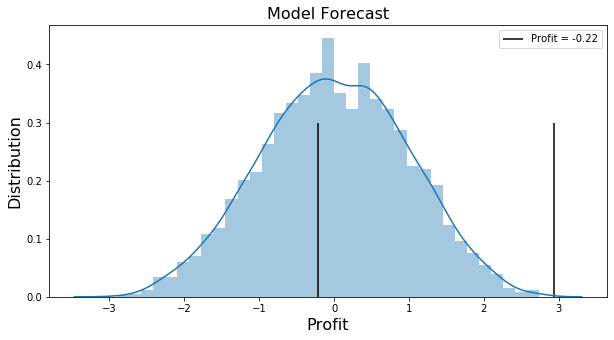

In [228]:
h=16

X_train = ts['2017':'2019-11']
y_train = data[['USD']].shift(h).loc[X_train.index]
y_train.columns = ['USD/AUD Rate {} days from current day'.format(h)]

test = ts['2019-12'][-h:]  #Last 16 days of December 
y = ts['2020'][:h]['USD']  #First 16 days of January

profit_percs = []
profit_medians = []
mean_mse, mean_mae = [], []

for params in top4_mlp_subset['activation, tol, alpha, solver']:
    
    activation, tol, alpha, solver = params
    
    model = MLPRegressor(shuffle=False,
                         random_state=42, 
                         tol=tol,
                         activation=activation,
                         alpha=alpha,
                         solver=solver)

 
    model.fit(X_train, y_train)

    
    y_pred = model.predict(test) #Predictions for first 16 days of January

#     fig, ax1 = plt.subplots(figsize=(10,5))

#     ax1.plot(y.index, y, label='Actual')
#     ax1.plot(y.index, y_pred, color='red', label='Predicted')
#     ax1.legend()
#     fig.show()
    
    
    
    model_profit, model_equity = backtest(y, y_pred)
    
    fig, ax = plt.subplots(figsize=(10,5))
    
    _ = random_simulation(y, model_profit, ax=ax)
    
#     profit_percs.append(profit_perc)
#     profit_medians.append(profit_median)
    
#     mse_cv, mae_cv = other_metrics(model=model)
    
#     mean_mse.append(mse_cv)
#     mean_mae.append(mae_cv)
    
# evaluation_df = pd.DataFrame({"params" : top4_mlp_subset['activation, tol, alpha, solver'],
#                               "profit_percentage" : profit_percs, 
#                               "profit_median" : profit_medians, 
#                               "mse" : mean_mse,
#                               "mse"})

# evaluation_df

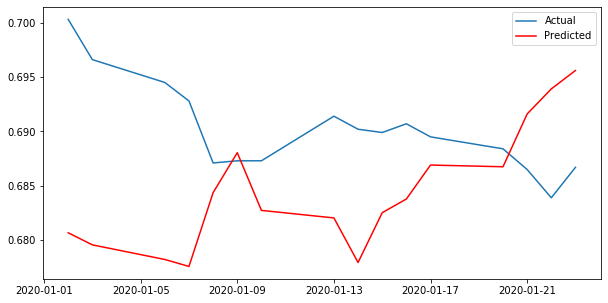

In [229]:
fig, ax1 = plt.subplots(figsize=(10,5))

ax1.plot(y.index, y, label='Actual')
ax1.plot(y.index, y_pred, color='red', label='Predicted')
ax1.legend()


In [230]:
def model_evaluation(h, verbose=True, model=Ridge()):

    df_2020 = ts['2019-12':'2020-2'].drop('USD', axis=1)
    no_h_day_periods = int(len(df_2020)/h)
    
    if verbose==True:
        print("Number of {} day periods in 2020 = {}".format(h, no_h_day_periods))

    X_train = ts['2017':'2019-11'].drop('USD', axis=1)
    y_train = data[['USD']].shift(h).loc[X_train.index]
    y_train.columns = ['USD/AUD Rate {} days from today'.format(h)]

    model_fit = model.fit(X_train, y_train)

    period_id = np.arange(0, h * no_h_day_periods, h)

    h_profits = []
    period_start_dates = []

    for start in period_id:
        end = start + h

        test = df_2020[start : end]

    #     print("Start date = ", test.index.min().date())
    #     print("End date = ", test.index.max().date())

        if start == 0:
            None
        else:
            y = ts.loc[test.index]['USD']
            y_pred = model.predict(previous_h_days)

    #         fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,5))

    #         ax1.plot(y.index, y, label='Actual')
    #         ax1.plot(y.index, y_pred, color='red', label='Predicted')
    #         ax1.legend()

            model_profit, equity = backtest(y, y_pred)
            h_profits.append(model_profit)
            period_start_dates.append(test.index.min().date())

    #         _ = random_simulation(y, model_profit, ax=ax2)

#             fig.show()

        previous_h_days = test
    
    if verbose==True:
        fig, ax = plt.subplots(figsize=(10,5))

        sns.boxplot(h_profits)
        sns.swarmplot(h_profits, color='orange')
        ax.vlines(0, 0, 20, color='black')
        ax.set_title("Profit Distribution for 2020 (forecast horizon = {})".format(h))
        ax.set_xlabel("Profit", fontsize=16)
#         ax.legend([model])
        fig.show()

    p = np.array(h_profits) 
    losses = p[p < 0]
    profits = p[p > 0]
    
    try:
        profit_perc = (len(profits) / (no_h_day_periods - 1)) * 100
    except:    
        profit_perc = (len(profits) / (no_h_day_periods)) * 100

        
    
    if verbose==True:
        print("{} : Percentage of periods with profit = {}".format(h, profit_perc))
        
    
    return profit_perc, np.median(p)

In [231]:
def plot_model_profit_metrics(H = np.arange(1, 35, 1), model=Ridge()):

    profit_percentages = []
    profit_medians = []

    for h in H:
        profit_perc, profit_median = model_evaluation(h, verbose=False, model=model)
        profit_percentages.append(profit_perc)
        profit_medians.append(profit_median)

    profit_percentages = np.asarray(profit_percentages)
    profit_medians = np.asarray(profit_medians)

    perc_median_sum = profit_medians + profit_percentages

    fig, (ax1, ax2) = plt.subplots(2, figsize=(20,15))

    max_perc = np.argmax(profit_percentages)
    max_sum = np.argmax(perc_median_sum)
    
    print("Best h = {}".format(max_perc + 1))

    ax1.plot(H, profit_percentages)
    ax1.scatter(max_perc + 1, profit_percentages[max_perc], marker='x', s=100, c='red')
    ax1.vlines(max_perc+1, 0, profit_percentages[max_perc])
    ax1.set_ylim([0,101])
    ax1.set_title("Percentage of Profit periods", fontsize=16)

    ax2.plot(H, perc_median_sum)
    ax2.scatter(max_sum+1, perc_median_sum[max_sum], marker='x', s=100, c='red')
    ax2.vlines(max_sum+1, 0, perc_median_sum[max_sum])
    ax2.set_ylim([0,101])
    ax2.set_title("Sum of Profit Percentage and Profit Median", fontsize=16)
    
    ax2.legend([model])
    fig.show()

Best h = 14
Best h = 14
Best h = 14
Best h = 14


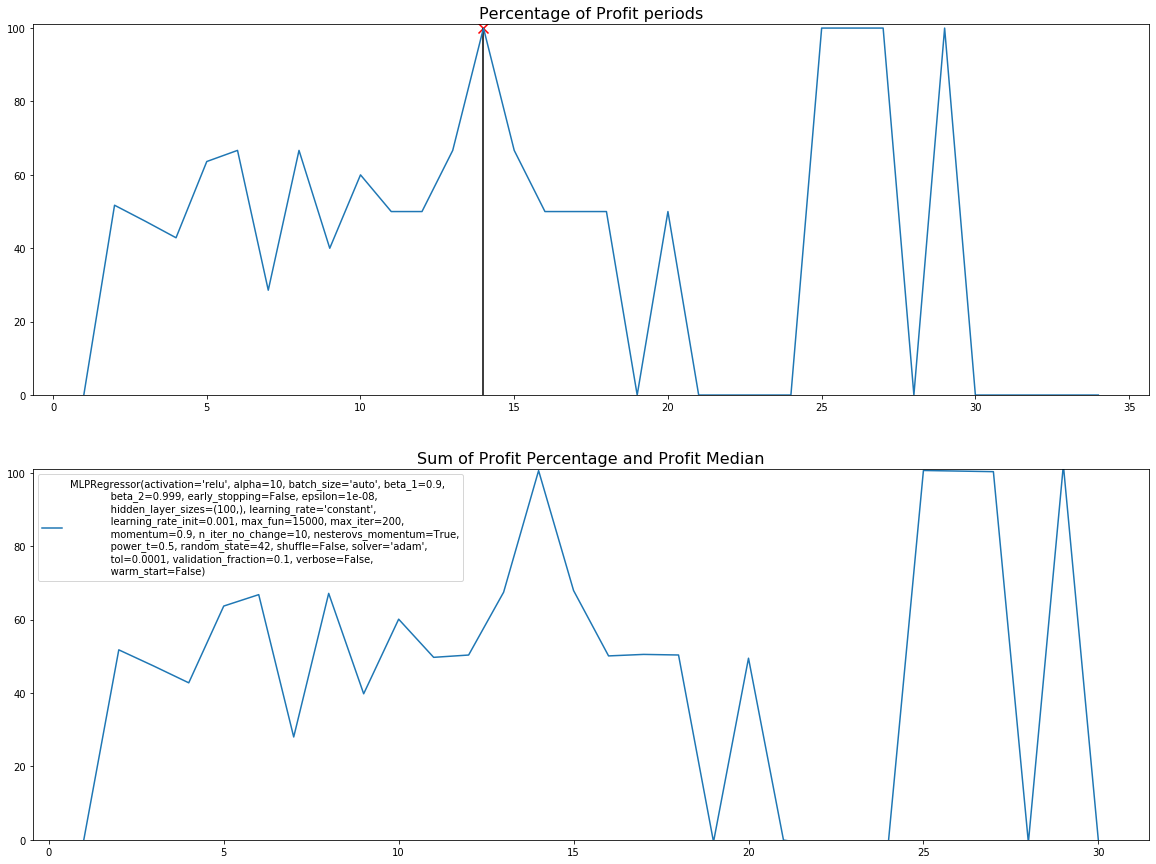

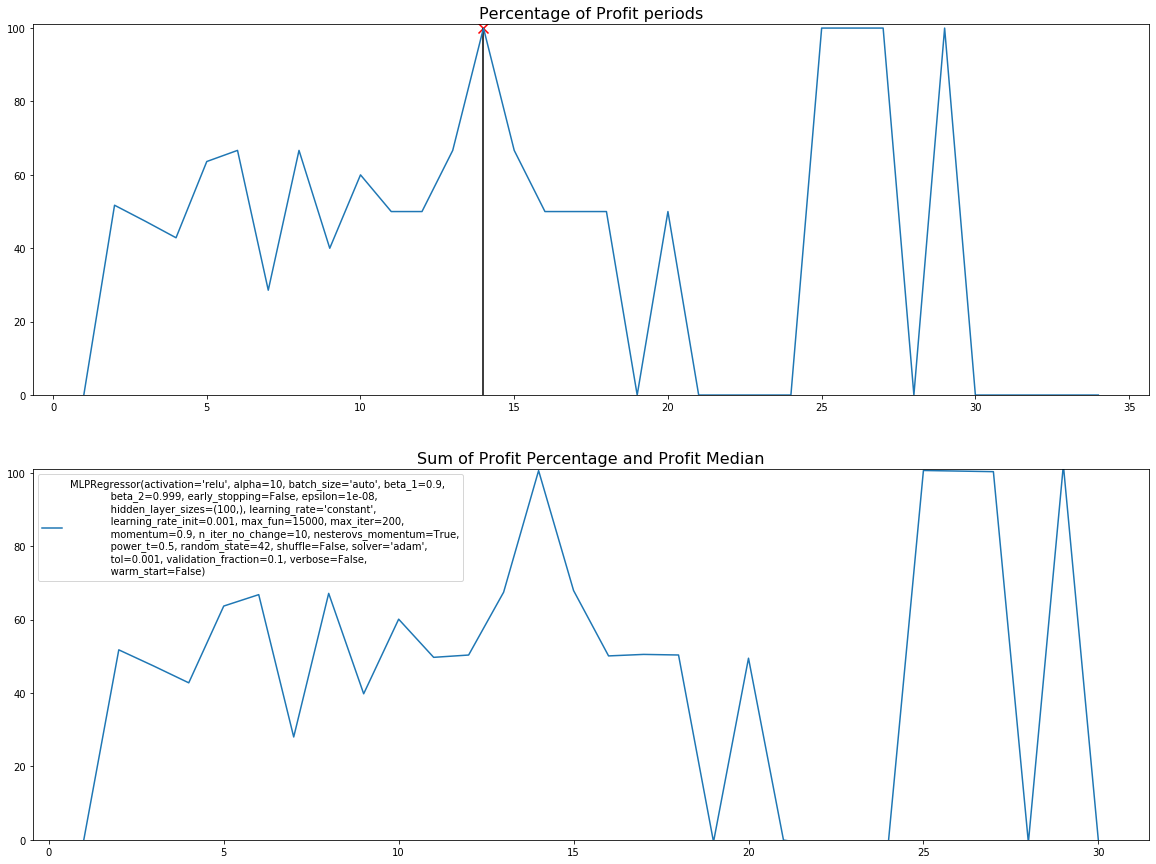

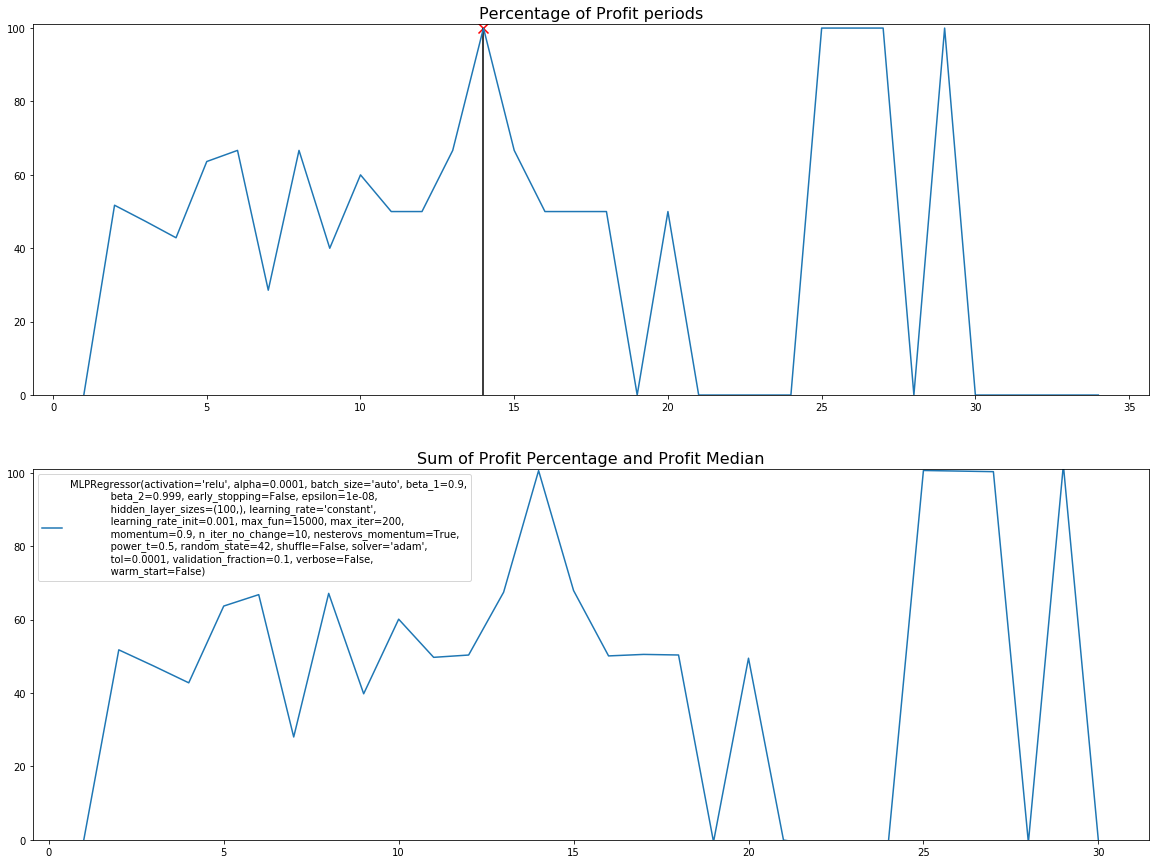

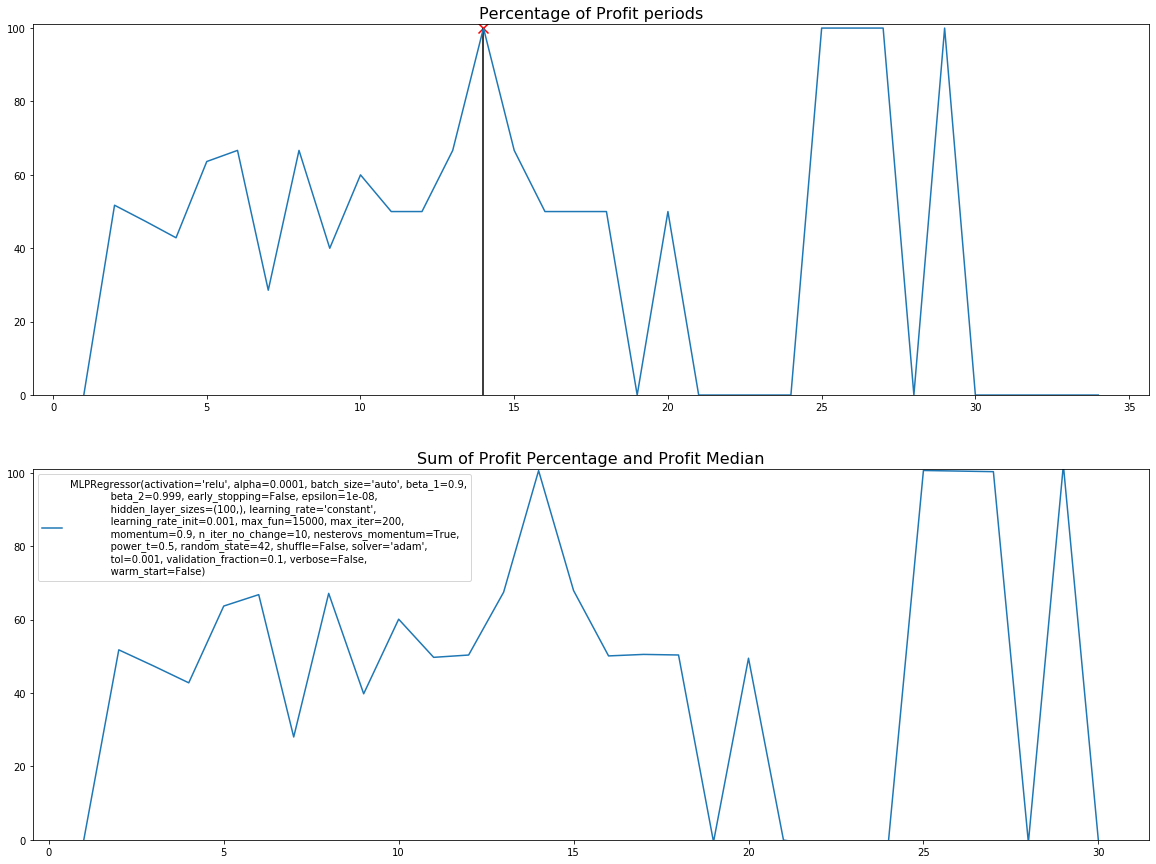

In [232]:
for params in top4_mlp_subset['activation, tol, alpha, solver']:
    
    activation, tol, alpha, solver = params

    model = MLPRegressor(shuffle=False,
                         random_state=42, 
                         tol=tol,
                         activation=activation,
                         alpha=alpha,
                         solver=solver)

    plot_model_profit_metrics(model=model)

Number of 14 day periods in 2020 = 4
14 : Percentage of periods with profit = 100.0


(100.0, 0.6000000000001364)

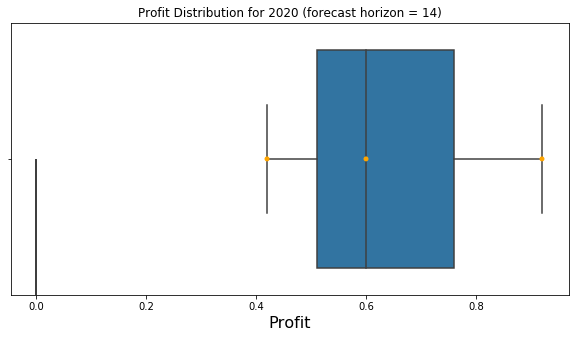

In [233]:
model_evaluation(h=14, model=model)

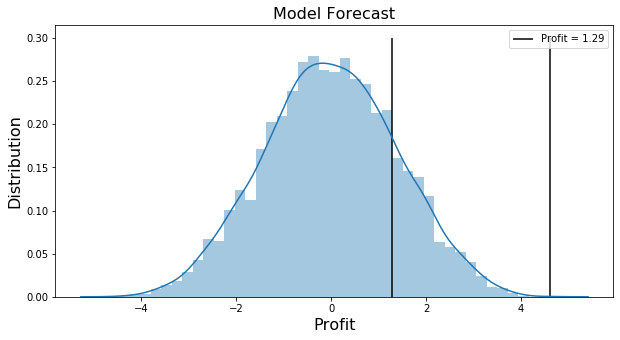

In [234]:
X_train = ts['2017':'2019-11'].drop('USD', axis=1)
y_train = data[['USD']].shift(h).loc[X_train.index]
y_train.columns = ['USD/AUD Rate {} days from today'.format(h)]

X_test = ts[:'2020-03'].shift(h).drop('USD', axis=1)[-h:]
current_rates = ts['2020-02-17':][-h:]['USD']

model = MLPRegressor(shuffle=False,
                     random_state=42, 
                     tol=tol,
                     activation=activation,
                     alpha=alpha,
                     solver=solver)

model.fit(X_train, y_train)

current_rate_preds = model.predict(X_test)

model_profit, model_equity = backtest(current_rates, current_rate_preds)

fig, ax = plt.subplots(figsize=(10,5))

_ = random_simulation(current_rates, model_profit, ax=ax)